In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR
import torch.optim as optim
import matplotlib.pyplot as plt
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)
    
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn_weights = (q @ k.transpose(-2, -1)) * (1.0 / self.head_dim ** 0.5)
        attn_weights = attn_weights.softmax(dim=-1)
        
        attn_output = (attn_weights @ v).transpose(1, 2).reshape(B, N, C)
        attn_output = self.proj(attn_output)
        return attn_output

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout):
        super(TransformerEncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=256, num_heads=8, mlp_dim=512, num_layers=6, num_classes=100, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.num_patches, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        self.encoder = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, dropout)
        for _ in range(num_layers)])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for layer in self.encoder:
            x = layer(x)
        
        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x

In [8]:

def train_and_evaluate(model, trainloader, testloader, num_epochs=50, learning_rate=3e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.1)
    scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        LinearLR(optimizer, start_factor=0.1, total_iters=10),
        CosineAnnealingLR(optimizer, T_max=num_epochs -10)
    ],
    milestones=[10]
    )

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')
        scheduler.step()
     # 绘制损失和准确度曲线
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # 绘制训练损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制训练和测试准确度曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, test_accuracies, 'r', label='Test accuracy')
    plt.title('Training and Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/50], Loss: 4.1232, Train Accuracy: 7.37%, Test Accuracy: 10.80%
Epoch [2/50], Loss: 3.7196, Train Accuracy: 13.22%, Test Accuracy: 16.54%
Epoch [3/50], Loss: 3.4209, Train Accuracy: 18.20%, Test Accuracy: 20.09%
Epoch [4/50], Loss: 3.1679, Train Accuracy: 22.33%, Test Accuracy: 23.93%
Epoch [5/50], Loss: 2.9774, Train Accuracy: 25.94%, Test Accuracy: 27.32%
Epoch [6/50], Loss: 2.8275, Train Accuracy: 28.72%, Test Accuracy: 30.09%
Epoch [7/50], Loss: 2.7137, Train Accuracy: 30.65%, Test Accuracy: 31.75%
Epoch [8/50], Loss: 2.6041, Train Accuracy: 33.03%, Test Accuracy: 34.02%
Epoch [9/50], Loss: 2.5060, Train Accuracy: 34.93%, Test Accuracy: 35.58%
Epoch [10/50], Loss: 2.4255, Train Accuracy: 36.59%, Test Accuracy: 35.85%
Epoch [11/50], Loss: 2.3420, Train Accuracy: 38.20%, Test Accuracy: 38.13%
Epoch [12/50], Loss: 2.2396, Train Accuracy: 40.83%, Test Accuracy: 39.16%
Epoch [13/50], Loss: 2.1353, Train

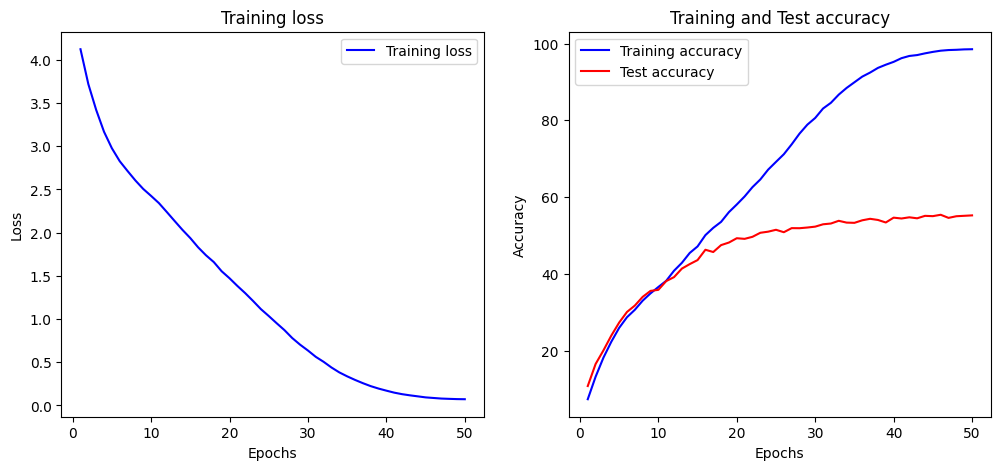

In [9]:
# 数据集和数据加载器
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
warmup_epochs = 10
train_and_evaluate(model, train_loader, test_loader, num_epochs=50, learning_rate=3e-4)
torch.save(model, 'train_50'  + '.pth')   

